In [1]:
using Distributions
using HypothesisTests
using Random
using StatsBase: ecdf
using StatsPlots
default(fmt=:png, titlefontsize=10, tickfontsize=6,
    guidefontsize=9, plot_titlefontsize=10)

In [2]:
distname(dist) = replace(string(dist), r"{[^}]*}"=>"")

function distname(dist::LocationScale)
    μ, σ, ρ = params(dist)
    μ = round(μ; digits=3)
    σ = round(σ; digits=3)
    μ == 0 ? "$σ $(distname(ρ))" : "$μ + $σ $(distname(ρ))"
end

distname (generic function with 2 methods)

In [3]:
"""
    nextcombination!(n, t, c = typeof(t)[min(t-1, i) for i in 1:t])

`[1,2,…,n]` からの重複無しの `t` 個の組み合わせ `c` をすべて生成したい.

`nextcombination!(n, t, c)` は配列で表現された組み合わせ `c` をその次の組み合わせに書き換えて, `c` を返す.

初期条件を `c = typeof(t)[min(t-1, i) for i in 1:t]` にすると, `binomial(n, t)` 回の `nextcombination!(n, t, c)` ですべての組み合わせが生成される.
"""
function nextcombination!(n, t, c = typeof(t)[min(t-1, i) for i in 1:t])
    t == 0 && return c
    @inbounds for i in t:-1:1
        c[i] += 1
        c[i] > (n - (t - i)) && continue
        for j in i+1:t
            c[j] = c[j-1] + 1
        end
        break
    end
    c
end

"""
    mycombinations!(n::Integer, t, c)

事前に割り当てられた組み合わせを格納する配列 `c` を使って, `[1,2,…,n]` からの重複無しの `t` 個の組み合わせのすべてを生成する生成子を返す.
"""
function mycombinations!(n::Integer, t, c)
    for i in 1:t c[i] = min(t - 1, i) end
    (nextcombination!(n, t, c) for _ in 1:binomial(n, t))
end

"""
    mycombinations!(a, t, c)

事前に割り当てられた組み合わせを格納する配列 `c` を使って, 配列 `a` からのインデックスに重複がない `t` 個の組み合わせのすべてを生成する生成子を返す.
"""
function mycombinations!(a, t, c)
    t < 0 && (t = length(a) + 1)
    (view(a, indices) for indices in mycombinations!(length(a), t, c))
end

"""
    mycombinations(x, t)

`x` が整数ならば `[1,2,…,x]` からの, `x` が配列ならば `x` からのインデックスに重複がない `t` 個の組み合わせのすべてを生成する生成子を返す.
"""
mycombinations(x, t) = mycombinations!(x, t, Vector{typeof(t)}(undef, t))

mycombinations

In [4]:
using StatsBase: _tiedrank!

"""
    mytiedrank(X,
        rank = similar(X, Float64),
        place = similar(X, Int))

配列 `X` 内の値の順位(下から何番目に大きいか)を計算する.

値に重複がある場合には同順位にするために順位の平均を順位として採用する.

`rank`, `place` は内部で使う配列で, 事前に割り当てておけば, この函数はメモリ割り当てゼロで実行される.  `rank` が返り値になる.
"""
function mytiedrank(X,
        rank = similar(X, Float64),
        place = similar(X, Int))
    # Xの要素が整数ならば sortperm(X) を使った方がずっと速い.
    # そうなる理由は sortperm は sort! と違って sortperm_int_range も使用するから.
    # その代わりに sortperm だとメモリ割り当てが発生する.
    # この辺は Base 自体に改善の余地が残っているように思われる.
    #place = sortperm(X)
    place .= axes(place, 1)
    sort!(place; by = i -> @inbounds(X[i]))
    _tiedrank!(rank, X, place)
end

mytiedrank

In [5]:
"""
    exact_mann_whitney_u(x, y,
        xy = Vector{promote_type(eltype(x), eltype(y))}(undef, length(x)+length(y)),
        rankxy = similar(xy, Float64),
        place = similar(xy, Int),
        c = similar(x, Int, min(length(x), length(y)))
    )

データ `x, y` に関するMann-WhitneyのU検定のexact版を素朴なアルゴリズム(遅い)で実行し, `(u, u_less, u_greater, p_twosided, p_less, p_greater)` を返す.  ここで,

* `u` は `x`, `y` の `length` が小さい方のU統計量達.
* `u_less`, `u_greater` はそれぞれ `u`, `length(x)*length(y) - u` の小さい方と大きい方.
* `p_twosided` は両側検定のP値.
* `p_less` は `u_less` 以下になる確率.
* `p_greater` は `u_greater` 以上になる確率.

`p_twosided` は `p_less + p_greater` と1の小さい方になる.

`xy`, `rankxy`, `place`, `comb` は内部で使用する配列である. それらを事前に割り当てておけば, この函数はメモリ割り当てゼロで実行される.

この函数の実装では素朴にすべての組み合わせに関する和を計算する方法を採用しているので, `x`, `y` のサイズが大きくなると極めて遅くなる.  より洗練されたアルゴリズムについては以下の文献を参照せよ.

* https://pure.tue.nl/ws/files/1330412/200012964.pdf
* https://www.sciencedirect.com/science/article/pii/S1672022916000358

注意: この函数が返す両側検定のP値はR言語の [exactRankTests::wilcox.exact](https://rdrr.io/cran/exactRankTests/src/R/wilcox.exact.R) や [coin::wilcox_test](https://rdrr.io/cran/coin/src/R/LocationTests.R) と同じ値になる.  それらは素朴な実装を採用しているこの函数よりも計算が速い.

注意: この函数が返す両側検定のP値は [HypothesisTests.jl](https://github.com/JuliaStats/HypothesisTests.jl) の `pvalue(ExactMannWhitneyUTest(x, y))` とは一般に異なる.  そうなる理由は HypothesisTests.jl が `[x; y]` 内の値に重複(tie)がある場合に分布の左右対称性が崩れることに配慮していないからである.  さらに現時点の HypothesisTests.jl (v0.10.10) の `pvalue(ExactMannWhitneyUTest(x, y))` ではメモリ割り当てがかなり発生する.

注意: この函数が返す両側検定のP値は [scipy.stats.mannwhitneyu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) とは一般に異なる.  その理由は仕様的に "No correction is made for ties." となっているからである.
"""
function exact_mann_whitney_u(x, y,
        xy = Vector{promote_type(eltype(x), eltype(y))}(undef, length(x)+length(y)),
        rankxy = similar(xy, Float64),
        place = similar(xy, Int),
        comb = similar(x, Int, min(length(x), length(y)))
    )
    # Assume length(x) ≤ length(y)
    if length(x) > length(y)
        return exact_mann_whitney_u(y, x, xy, rankxy, place, comb)
    end
    
    # Initialization
    m, n = length(x), length(y)
    xy[1:m] .= x
    xy[m+1:m+n] .= y

    # Calculation of ranks
    rankxy = mytiedrank(xy, rankxy, place)
    
    # Calculation of P-values
    r = sum(@view rankxy[1:m]) # rank sum of the data x,y
    r_less, r_greater = minmax(r, m*(m+n+1) - r)
    num_less, num_greater = 0, 0
    for c in mycombinations!(rankxy, m, comb)
        R = sum(c) # rank sum of the combination c
        num_less    += R ≤ r_less
        num_greater += R ≥ r_greater
    end
    p_less, p_greater = (num_less, num_greater) ./ binomial(m+n, m)
    p_twosided = min(1, p_less + p_greater)
    
    # Calculation of U-statistics
    u, u_less, u_greater = (r, r_less, r_greater) .- m*(m+1)÷2
    
    # Returns
    u, u_less, u_greater, p_twosided, p_less, p_greater
end

@doc exact_mann_whitney_u

```
exact_mann_whitney_u(x, y,
    xy = Vector{promote_type(eltype(x), eltype(y))}(undef, length(x)+length(y)),
    rankxy = similar(xy, Float64),
    place = similar(xy, Int),
    c = similar(x, Int, min(length(x), length(y)))
)
```

データ `x, y` に関するMann-WhitneyのU検定のexact版を素朴なアルゴリズム(遅い)で実行し, `(u, u_less, u_greater, p_twosided, p_less, p_greater)` を返す.  ここで,

  * `u` は `x`, `y` の `length` が小さい方のU統計量達.
  * `u_less`, `u_greater` はそれぞれ `u`, `length(x)*length(y) - u` の小さい方と大きい方.
  * `p_twosided` は両側検定のP値.
  * `p_less` は `u_less` 以下になる確率.
  * `p_greater` は `u_greater` 以上になる確率.

`p_twosided` は `p_less + p_greater` と1の小さい方になる.

`xy`, `rankxy`, `place`, `comb` は内部で使用する配列である. それらを事前に割り当てておけば, この函数はメモリ割り当てゼロで実行される.

この函数の実装では素朴にすべての組み合わせに関する和を計算する方法を採用しているので, `x`, `y` のサイズが大きくなると極めて遅くなる.  より洗練されたアルゴリズムについては以下の文献を参照せよ.

  * https://pure.tue.nl/ws/files/1330412/200012964.pdf
  * https://www.sciencedirect.com/science/article/pii/S1672022916000358

注意: この函数が返す両側検定のP値はR言語の [exactRankTests::wilcox.exact](https://rdrr.io/cran/exactRankTests/src/R/wilcox.exact.R) や [coin::wilcox_test](https://rdrr.io/cran/coin/src/R/LocationTests.R) と同じ値になる.  それらは素朴な実装を採用しているこの函数よりも計算が速い.

注意: この函数が返す両側検定のP値は [HypothesisTests.jl](https://github.com/JuliaStats/HypothesisTests.jl) の `pvalue(ExactMannWhitneyUTest(x, y))` とは一般に異なる.  そうなる理由は HypothesisTests.jl が `[x; y]` 内の値に重複(tie)がある場合に分布の左右対称性が崩れることに配慮していないからである.  さらに現時点の HypothesisTests.jl (v0.10.10) の `pvalue(ExactMannWhitneyUTest(x, y))` ではメモリ割り当てがかなり発生する.

注意: この函数が返す両側検定のP値は [scipy.stats.mannwhitneyu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) とは一般に異なる.  その理由は仕様的に "No correction is made for ties." となっているからである.


In [6]:
function sim(;
        distx = Normal(50, 1),
        disty = Normal(50, 1),
        m = 5,
        n = 5,
        L = 10^5,
        calc_exact = true
    )
    tmpx = [Vector{Float64}(undef, m) for _ in 1:Threads.nthreads()]
    tmpy = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    if calc_exact
        tmpxy = [Vector{Float64}(undef, m+n) for _ in 1:Threads.nthreads()]
        tmprankxy = [Vector{Float64}(undef, m+n) for _ in 1:Threads.nthreads()]
        tmpplace = [Vector{Int}(undef, m+n) for _ in 1:Threads.nthreads()]
        tmpcomb = [Vector{Int}(undef, min(m,n)) for _ in 1:Threads.nthreads()]
    end
    pval_ewmw = Vector{Float64}(undef, L)
    pval_awmw = Vector{Float64}(undef, L)
    Threads.@threads for i in 1:L
        x = rand!(distx, tmpx[Threads.threadid()])
        y = rand!(disty, tmpy[Threads.threadid()])
        if calc_exact
            result_ewmw = exact_mann_whitney_u(x, y,
                tmpxy[Threads.threadid()],
                tmprankxy[Threads.threadid()],
                tmpplace[Threads.threadid()],
                tmpcomb[Threads.threadid()]
            )
            pval_ewmw[i] = result_ewmw[4]
        end
        result_amwm = ApproximateMannWhitneyUTest(x, y)
        pval_awmw[i] = pvalue(result_amwm)
    end
    pval_ewmw, pval_awmw
end

sim (generic function with 1 method)

## 等分布の場合

In [7]:
Random.seed!(4649373)
m, n = 5, 5
pval_ewmw, pval_awmw = @time sim(; m, n, L=10^6)
ecdf_ewmw = ecdf(pval_ewmw)
f(x) = ecdf_ewmw(x)
ecdf_awmw = ecdf(pval_awmw)
g(x) = ecdf_awmw(x)

  3.769053 seconds (13.95 M allocations: 981.751 MiB, 2.04% gc time, 40.15% compilation time: 2% of which was recompilation)


g (generic function with 1 method)

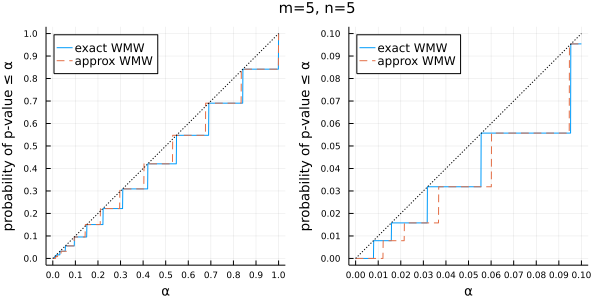

In [8]:
xmax = 1
tick = 0:xmax/10:xmax
x = 0:xmax/1000:xmax
P1 = plot(legend=:topleft)
plot!(x, f; label="exact WMW")
plot!(x, g; label="approx WMW", ls=:dash)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

xmax = 0.1
tick = 0:xmax/10:1
x = 0:xmax/1000:xmax
P2 = plot(legend=:topleft)
plot!(x, f; label="exact WMW")
plot!(x, g; label="approx WMW", ls=:dash)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

plot(P1, P2; size=(600, 300))
plot!(plot_title="m=$m, n=$n")

上のグラフはP値のecdf (経験累積分布函数)のプロットである.

以下の2つのプロットを比較すればわかるように, ヒストグラムはビンの取り方で大幅に印象が変わるので要注意である.

統計学入門の講義では「ヒストグラムは印象操作に悪用できるので要注意である」と教える必要がある.

ヒストグラムの代わりにecdf (経験累積分布函数)のグラフやQQプロットの類を使った方がよい場合は多い.

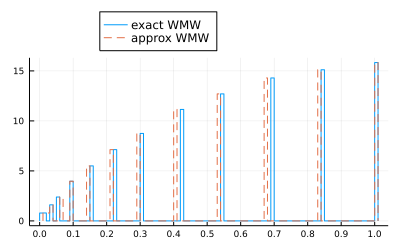

In [9]:
xmax = 1
tick = 0:xmax/10:xmax
bin = :auto
P1 = plot(legend=:outertop)
stephist!(pval_ewmw; norm=true, bin, label="exact WMW")
stephist!(pval_awmw; norm=true, bin, label="approx WMW", ls=:dash)
plot!(xtick=tick, size=(400, 250))

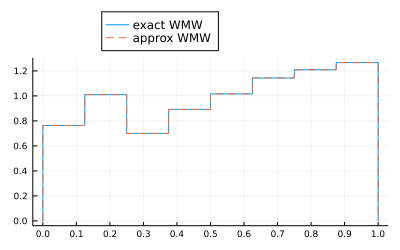

In [10]:
xmax = 1
tick = 0:xmax/10:xmax
bin = 0:(xmax+eps())/8:xmax+eps()
P1 = plot(legend=:outertop)
stephist!(pval_ewmw; norm=true, bin, label="exact WMW")
stephist!(pval_awmw; norm=true, bin, label="approx WMW", ls=:dash)
plot!(xtick=tick, size=(400, 250))

## 不等分散の場合

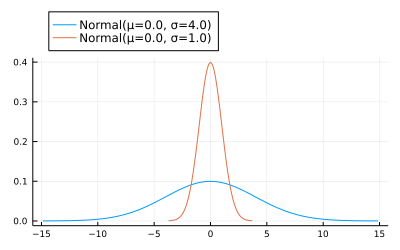

  0.265080 seconds (613.10 k allocations: 692.020 MiB, 24.30% gc time, 3.55% compilation time)


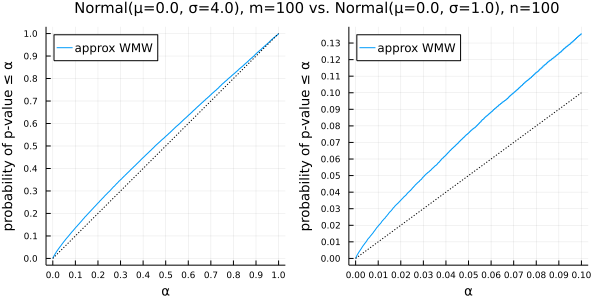

In [11]:
Random.seed!(4649373)
m, n = 100, 100
distx, disty = Normal(0, 4), Normal()
plot(distx; label=distname(distx))
plot!(disty; label=distname(disty))
plot!(size=(400, 250), legend=:outertop) |> display

pval_ewmw, pval_awmw = @time sim(; distx, disty, m, n, L=10^5, calc_exact=false)
#ecdf_ewmw = ecdf(pval_ewmw)
#f(x) = ecdf_ewmw(x)
ecdf_awmw = ecdf(pval_awmw)
g(x) = ecdf_awmw(x)

xmax = 1
tick = 0:xmax/10:xmax
x = 0:xmax/1000:xmax
P1 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

xmax = 0.1
tick = 0:xmax/10:1
x = 0:xmax/1000:xmax
P2 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

plot(P1, P2; size=(600, 300))
plot!(plot_title="$(distname(distx)), m=$m vs. $(distname(disty)), n=$n")

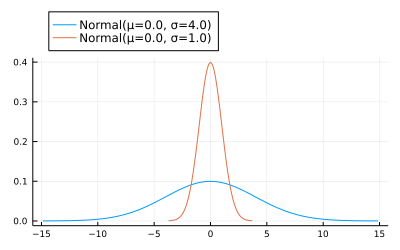

  0.420767 seconds (600.11 k allocations: 524.928 MiB, 63.92% gc time)


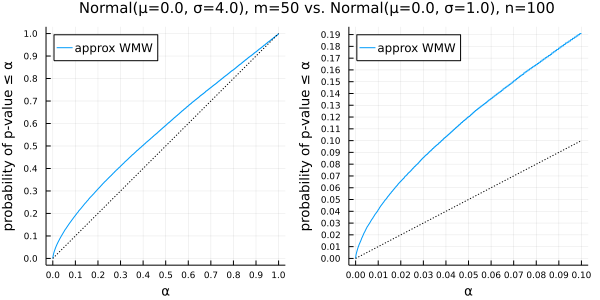

In [12]:
Random.seed!(4649373)
m, n = 50, 100
distx, disty = Normal(0, 4), Normal()
plot(distx; label=distname(distx))
plot!(disty; label=distname(disty))
plot!(size=(400, 250), legend=:outertop) |> display

pval_ewmw, pval_awmw = @time sim(; distx, disty, m, n, L=10^5, calc_exact=false)
#ecdf_ewmw = ecdf(pval_ewmw)
#f(x) = ecdf_ewmw(x)
ecdf_awmw = ecdf(pval_awmw)
g(x) = ecdf_awmw(x)

xmax = 1
tick = 0:xmax/10:xmax
x = 0:xmax/1000:xmax
P1 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

xmax = 0.1
tick = 0:xmax/10:1
x = 0:xmax/1000:xmax
P2 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

plot(P1, P2; size=(600, 300))
plot!(plot_title="$(distname(distx)), m=$m vs. $(distname(disty)), n=$n")

## 等分散かつ不等分布の場合

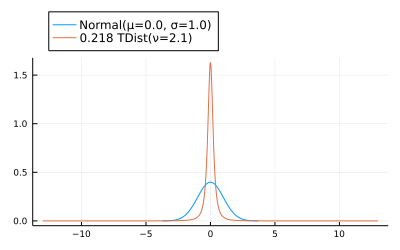

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
  0.388588 seconds (1.19 M allocations: 383.868 MiB, 9.11% gc time, 65.69% compilation time)


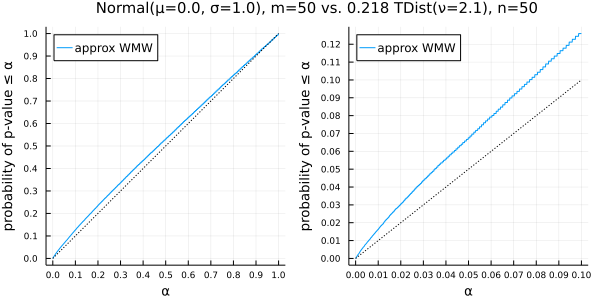

In [13]:
Random.seed!(4649373)
m, n = 50, 50
ν = 2.1
distx, disty = Normal(), √((ν-2)/ν)*TDist(ν)
plot(distx; label=distname(distx))
plot!(disty; label=distname(disty))
plot!(size=(400, 250), legend=:outertop) |> display

@show mean(distx), std(distx)
@show mean(disty), std(disty)
pval_ewmw, pval_awmw = @time sim(; distx, disty, m, n, L=10^5, calc_exact=false)
#ecdf_ewmw = ecdf(pval_ewmw)
#f(x) = ecdf_ewmw(x)
ecdf_awmw = ecdf(pval_awmw)
g(x) = ecdf_awmw(x)

xmax = 1
tick = 0:xmax/10:xmax
x = 0:xmax/1000:xmax
P1 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

xmax = 0.1
tick = 0:xmax/10:1
x = 0:xmax/1000:xmax
P2 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

plot(P1, P2; size=(600, 300))
plot!(plot_title="$(distname(distx)), m=$m vs. $(distname(disty)), n=$n")

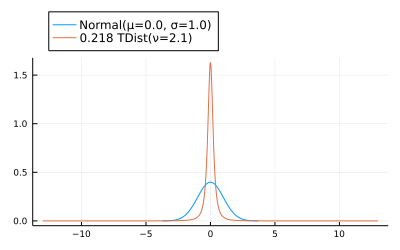

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
  0.228355 seconds (600.22 k allocations: 524.936 MiB)


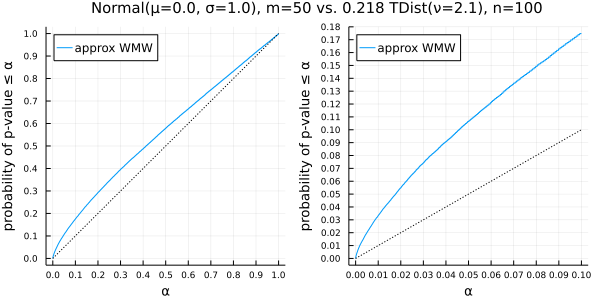

In [14]:
Random.seed!(4649373)
m, n = 50, 100
ν = 2.1
distx, disty = Normal(), √((ν-2)/ν)*TDist(ν)
plot(distx; label=distname(distx))
plot!(disty; label=distname(disty))
plot!(size=(400, 250), legend=:outertop) |> display

@show mean(distx), std(distx)
@show mean(disty), std(disty)
pval_ewmw, pval_awmw = @time sim(; distx, disty, m, n, L=10^5, calc_exact=false)
#ecdf_ewmw = ecdf(pval_ewmw)
#f(x) = ecdf_ewmw(x)
ecdf_awmw = ecdf(pval_awmw)
g(x) = ecdf_awmw(x)

xmax = 1
tick = 0:xmax/10:xmax
x = 0:xmax/1000:xmax
P1 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

xmax = 0.1
tick = 0:xmax/10:1
x = 0:xmax/1000:xmax
P2 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

plot(P1, P2; size=(600, 300))
plot!(plot_title="$(distname(distx)), m=$m vs. $(distname(disty)), n=$n")

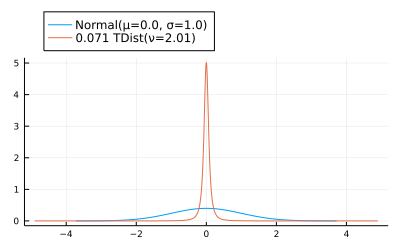

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
  0.133183 seconds (600.21 k allocations: 354.033 MiB)


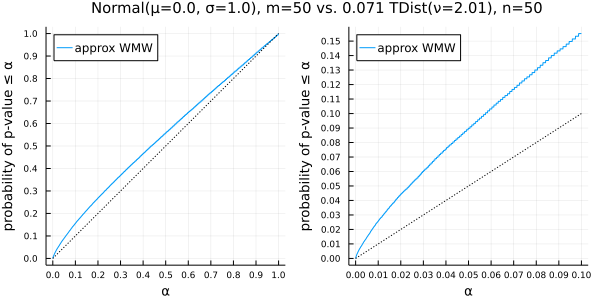

In [15]:
Random.seed!(4649373)
m, n = 50, 50
ν = 2.01
distx, disty = Normal(), √((ν-2)/ν)*TDist(ν)
plot(distx; label=distname(distx))
plot!(disty; label=distname(disty))
plot!(size=(400, 250), legend=:outertop) |> display

@show mean(distx), std(distx)
@show mean(disty), std(disty)
pval_ewmw, pval_awmw = @time sim(; distx, disty, m, n, L=10^5, calc_exact=false)
#ecdf_ewmw = ecdf(pval_ewmw)
#f(x) = ecdf_ewmw(x)
ecdf_awmw = ecdf(pval_awmw)
g(x) = ecdf_awmw(x)

xmax = 1
tick = 0:xmax/10:xmax
x = 0:xmax/1000:xmax
P1 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

xmax = 0.1
tick = 0:xmax/10:1
x = 0:xmax/1000:xmax
P2 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

plot(P1, P2; size=(600, 300))
plot!(plot_title="$(distname(distx)), m=$m vs. $(distname(disty)), n=$n")

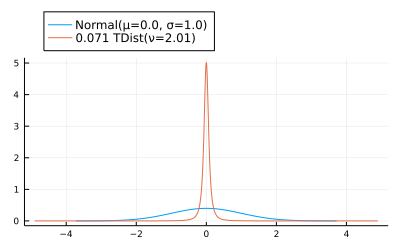

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
  0.230317 seconds (600.22 k allocations: 524.936 MiB)


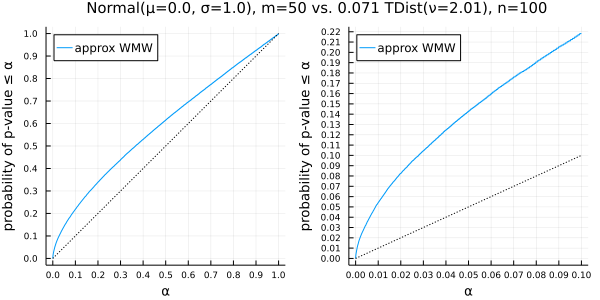

In [16]:
Random.seed!(4649373)
m, n = 50, 100
ν = 2.01
distx, disty = Normal(), √((ν-2)/ν)*TDist(ν)
plot(distx; label=distname(distx))
plot!(disty; label=distname(disty))
plot!(size=(400, 250), legend=:outertop) |> display

@show mean(distx), std(distx)
@show mean(disty), std(disty)
pval_ewmw, pval_awmw = @time sim(; distx, disty, m, n, L=10^5, calc_exact=false)
#ecdf_ewmw = ecdf(pval_ewmw)
#f(x) = ecdf_ewmw(x)
ecdf_awmw = ecdf(pval_awmw)
g(x) = ecdf_awmw(x)

xmax = 1
tick = 0:xmax/10:xmax
x = 0:xmax/1000:xmax
P1 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

xmax = 0.1
tick = 0:xmax/10:1
x = 0:xmax/1000:xmax
P2 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

plot(P1, P2; size=(600, 300))
plot!(plot_title="$(distname(distx)), m=$m vs. $(distname(disty)), n=$n")

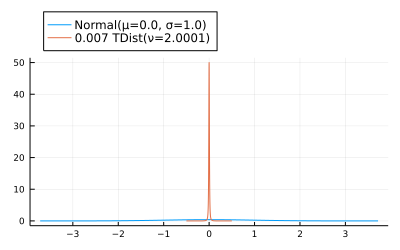

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 0.9999999999999999)
  0.148272 seconds (600.21 k allocations: 354.033 MiB)


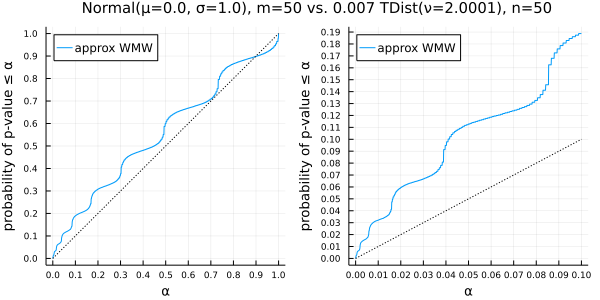

In [17]:
Random.seed!(4649373)
m, n = 50, 50
ν = 2.0001
distx, disty = Normal(), √((ν-2)/ν)*TDist(ν)
plot(distx; label=distname(distx))
plot!(disty; label=distname(disty))
plot!(size=(400, 250), legend=:outertop) |> display

@show mean(distx), std(distx)
@show mean(disty), std(disty)
pval_ewmw, pval_awmw = @time sim(; distx, disty, m, n, L=10^5, calc_exact=false)
#ecdf_ewmw = ecdf(pval_ewmw)
#f(x) = ecdf_ewmw(x)
ecdf_awmw = ecdf(pval_awmw)
g(x) = ecdf_awmw(x)

xmax = 1
tick = 0:xmax/10:xmax
x = 0:xmax/1000:xmax
P1 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

xmax = 0.1
tick = 0:xmax/10:1
x = 0:xmax/1000:xmax
P2 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

plot(P1, P2; size=(600, 300))
plot!(plot_title="$(distname(distx)), m=$m vs. $(distname(disty)), n=$n")

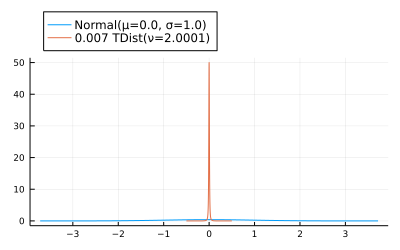

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 0.9999999999999999)
  0.213770 seconds (600.21 k allocations: 524.936 MiB)


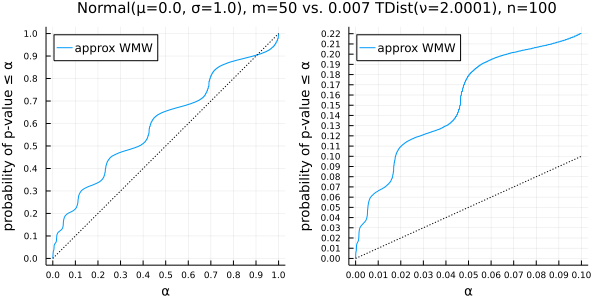

In [18]:
Random.seed!(4649373)
m, n = 50, 100
ν = 2.0001
distx, disty = Normal(), √((ν-2)/ν)*TDist(ν)
plot(distx; label=distname(distx))
plot!(disty; label=distname(disty))
plot!(size=(400, 250), legend=:outertop) |> display

@show mean(distx), std(distx)
@show mean(disty), std(disty)
pval_ewmw, pval_awmw = @time sim(; distx, disty, m, n, L=10^5, calc_exact=false)
#ecdf_ewmw = ecdf(pval_ewmw)
#f(x) = ecdf_ewmw(x)
ecdf_awmw = ecdf(pval_awmw)
g(x) = ecdf_awmw(x)

xmax = 1
tick = 0:xmax/10:xmax
x = 0:xmax/1000:xmax
P1 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

xmax = 0.1
tick = 0:xmax/10:1
x = 0:xmax/1000:xmax
P2 = plot(legend=:topleft)
#plot!(x, f; label="exact WMW", c=1)
plot!(x, g; label="approx WMW")#, ls=:dash, c=2)
plot!([0, xmax], [0, xmax]; label="", c=:black, ls=:dot)
plot!(xtick=tick, ytick=tick)
plot!(xguide="α", yguide="probability of p-value ≤ α")

plot(P1, P2; size=(600, 300))
plot!(plot_title="$(distname(distx)), m=$m vs. $(distname(disty)), n=$n")